In [1]:
import sqlalchemy
from sqlalchemy import create_engine, inspect, func
from sqlalchemy.orm import Session
from sqlalchemy.ext.automap import automap_base
Base= automap_base()
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
import numpy as np
import matplotlib.pyplot as plt

In [2]:
database_path='C:\workspace\Resources\hawaii.sqlite'
engine=create_engine(f'sqlite:///{database_path}')
conn= engine.connect()
Base.prepare(engine, reflect= True)
Base.classes.keys()
Measurement= Base.classes.measurement
Station= Base.classes.station
session=Session(engine)

In [3]:
# Temperature Analysis I
## Average temperature in June and Dec at all stations across all available years in the dataset
june='06'
dec='12'
average_june=session.query(func.avg(Measurement.tobs)).\
            filter(func.strftime("%m", Measurement.date) == june).all()
average_dec=session.query(func.avg(Measurement.tobs)).\
            filter(func.strftime("%m", Measurement.date) == dec).all()
print(f'Average temperature in June is {list(np.ravel(average_june))} and in December is {list(np.ravel(average_dec))}')

Average temperature in June is [74.94411764705882] and in December is [71.04152933421226]


In [4]:
##Use the t-test to determine whether the difference in the means, 
##if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

In [16]:
# Temperature Analysis II
## Calculate min, avg, max temps for the trip from 08/02/2017 to 08/12/2017
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
my_start='2017-02-28'
my_end='2012-03-05'
my_trip_data = list(np.ravel(calc_temps(my_start, my_end)))
my_trip_data

[62.0, 69.57142857142857, 74.0]

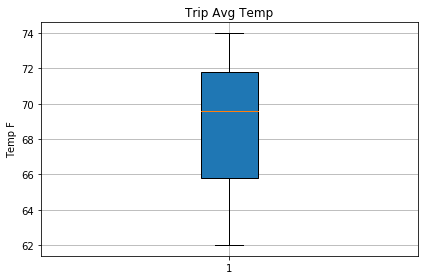

In [17]:
ptp=my_trip_data[2]-my_trip_data[0]
plt.boxplot(my_trip_data,patch_artist=True, meanline= True)
plt.title('Trip Avg Temp')
plt.ylabel('Temp F')
plt.grid()
plt.tight_layout()
plt.show()

In [24]:
# Daily Rainfall Average
# twelve_month_ago = dt.date(2017,8,23) - relativedelta(months=+12)
# now= dt.date(2017,8,23)
station_rain=[Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
station_rainfall= session.query(*station_rain).\
    filter(Station.station==Measurement.station).\
    filter(Measurement.date==my_start).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()
station_rainfall

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.4),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.05),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.03),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  0.0),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.0)]

In [25]:
def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]